# 0. Introduction

In [1]:
%matplotlib inline
import warnings;warnings.filterwarnings('ignore');import matplotlib.pyplot as plt;import numpy as np;import pandas as pd;import seaborn as sns;sns.set_context("notebook", font_scale=1.4);sns.set_style("whitegrid");import imp;compomics_import = imp.load_source('compomics_import', '../compomics_import.py');from IPython.core.display import HTML;css_file = '../my.css';HTML(open(css_file, "r").read())

Suppose we work for a pharmaceutical company and are asked to construct an instrument for the diagnosis of pigmented skin lesions from dermoscopic images such as these:

<br/>
![examples of pigmented skin lesionson](pigments1.jpg)
<br/>
<br/>


The images on the top row exhibit a sign of cancer (malignant). The images on the bottom row are not cancerous (benign). Nevertheless, all images look very much alike. The purpose of the instrument is to process such a dermoscopic image of a pigmented skin lesion and classify it as either malignant or benign. 

The following as a diagram that summarizes the approach we will follow for constructing the instrument:

<br/>
![diagram](diagram1.jpg)
<br/>
<br/>


The input of the instrument is a raw dermoscopic image of a lesion that needs to be interpreted in some way allowing for an accurate diagnosis. For this, we will create a **feature extraction** unit that implements methods for image segmentation and image filtering to extract certain measurements from an image that are related to the shape, colors and texture for each lesion in the images.

All these measurements are properties (termed **features** or **attributes**) of a legion which are potentially useful for making a correct diagnosis. Given that there truly are differences between benign and malignant lesions, we view them as being generated by different underlying models. Simply stated this means that they can be described differently and that the differences in the description can be used to make a correct diagnosis. However, as the dermoscopic images shown above suggest, both underlying models (benign and malignant) seem very similar. 

We are searching for those features that explain the differences between the model of a benign and the model of a malignant lesion with sufficient diagnostic accuracy. To search for these **discriminative features** we collect a set of images of lesions known to be malignant and lesions known to be benign and discuss our observations with experts.

According to the experts the ellipse eccentricity of a lesion (how circular the lesion is) as an important potential discriminative feature. So we program the feature extraction unit such that it computes an (estimated) eccentricity value for each lesion in each image. This creates a **data set** (or **data matrix**) with one row for each image (called a **data point** or **instance** or **example**) and two columns for each row: one column that contains the eccentricity value computed for the lesion in the image ('Eccentricity') and a column that contains the value '1' if the image contains a malignant lesion and '0' otherwise. This second column is called the **label** (or **class**) of the data point. For two-class classifiction tasks such we typically refer to one class as the **positive class** (in our case this is 'malignant') and the other class as the **negative class**.

Let's load this data set. We read the tab-separated file *eccentricity.csv* in a Python Pandas DataFrame:

In [2]:
dataset_ecc = pd.read_csv("eccentricity.csv",sep='\t')
print("First 5 data points:")
print()
print(dataset_ecc.head(5))
print()
print("Shape of data set: " + str(dataset_ecc.shape))

First 5 data points:

   Eccentricity  label
0      1.770190      1
1      0.952262      0
2      1.726489      1
3      0.344707      0
4     -0.138108      0

Shape of data set: (100, 2)


The data set contains 100 data points. Let's see how many data points there are for each class:

In [3]:
print(dataset_ecc["label"].value_counts())

1    50
0    50
Name: label, dtype: int64


The number of data points in each class is the same, we call this a **balanced** data set.


Our ﬁrst proposition for a model of a malignant cell is: malignant cells have some typical ellipse eccentricity, and this eccentricity is different from the eccentricity of benign cells. We can check this by plotting the values in the 'Eccentricity' column as two density histogram graphs: a blue one for malignant lesions and a green one for benign legions. 

We observe that the lesion's eccentricity is typically larger for malignant cells:

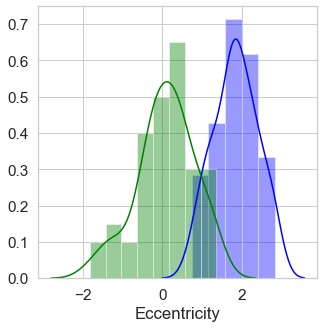

In [4]:
plt.figure(figsize=(5,5))
#call seaborn to plot a distribution plot in blue
sns.distplot(dataset_ecc[dataset_ecc.label==1]['Eccentricity'], color="b")
#call seaborn to plot a distribution plot in green
sns.distplot(dataset_ecc[dataset_ecc.label==0]['Eccentricity'], color="g")
plt.show()

The classiﬁer unit in our instrument can use this feature to perform a classiﬁcation (diagnosis) by checking whether or not the ellipse eccentricity of a lesion is larger than some **threshold value $t$**, in case the diagnosis is 'malignant'. 

Peter decides to set $t = 1$:

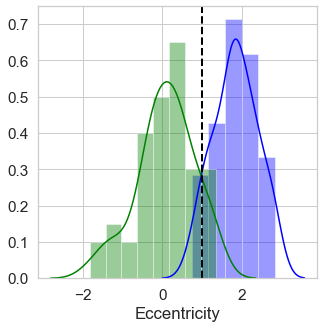

In [5]:
t=1

plt.figure(figsize=(5,5))
sns.distplot(dataset_ecc[dataset_ecc.label==1]['Eccentricity'], color="b")
sns.distplot(dataset_ecc[dataset_ecc.label==0]['Eccentricity'], color="g")
#draw a vertical line at x=t
plt.axvline(t, color='black', linestyle='dashed', linewidth=2)
plt.show()

So far we assumed that the **consequence of the predictions** made by the instrument are equally costly: classifying a malignant lesion as benign is just as undesirable as the converse. It is clear that for our instrument
classifying a malignant lesion as benign is more dramatic than classifying a benign legion as malignant.

We can take this **difference in cost between the classes** into account by adjusting the threshold value to $t = 0.7$. Thereby reducing the number of malignant lesions that are classiﬁed as benign in his data set, but increasing the number of benign lesions that are diagnosed as malignant:

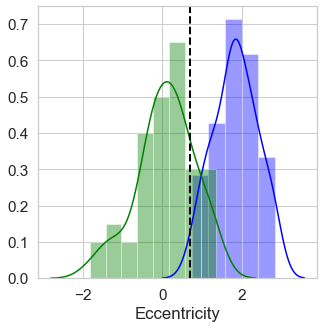

In [6]:
plt.figure(figsize=(5,5))
t = 0.7
sns.distplot(dataset_ecc[dataset_ecc.label==1]['Eccentricity'], color="b")
sns.distplot(dataset_ecc[dataset_ecc.label==0]['Eccentricity'], color="g")
plt.axvline(t, color='black', linestyle='dashed', linewidth=2)
plt.show()

So what value should $t$ be?

Such considerations suggest that there is an overall single cost associated with the classification and our true task
is to make a **decision rule**, or set a **decision boundary** (i.e. $t$) so as to minimize the specified cost.

For classification tasks these considerations are deduced from a **confusion matrix**. This matrix shows the **types of erros** made by a classifier. As stated before we say that the malignant lesions belong to the positive class and the benign lesions belong to the negative class.

Given the decision boundary $t$ for the 'Eccentricity' feature we can count the number of malignant lesions with eccentricity value $\ge t$. These are called the **true positive** classifications (TP) as the predicted class 'malignant' is correct. Those malignant lesions with eccentricity value $<t$ are called the **false negative** classifications (FN) as the predicted class 'benign' is incorrect. 

Similarly, benign lesions with eccentricity value $\ge t$ are called **false positive** classifications (FP) as the predicted class 'malignant' is incorrect. Those benign lesions with eccentricity value $<t$ are the **true negative** classifications (TN) as the predicted class 'benign' is correct.

In summary:

- #malignant lesions with eccentricity value $\ge t$: **true positives** (TP)

- #malignant lesions with eccentricity value $<t$: **false negatives** (FN)

- #benign lesions with eccentricity value $\ge t$: **false positives** (FP)

- #benign lesions with eccentricity value $<t$: **true negatives** (TN)

The different types of errors are usually represented in a **confusion matrix**. In scikit-learn there is a function called `confusion_matrix()` that computes the confusion matrix from true and predicted values:

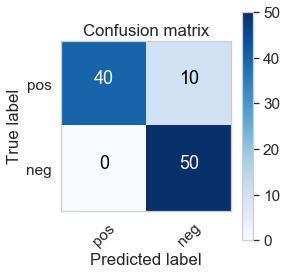


#TP = 40; #FP = 0; FN = 10; TN = 50


In [7]:
from sklearn import metrics

t=0.7
predictions = [1 if x >= t else 0 for x in dataset_ecc['Eccentricity']]

cm = metrics.confusion_matrix(dataset_ecc['label'],predictions)

plt.figure(figsize=(4,4))    
compomics_import.plot_confusion_matrix(cm,["pos","neg"])
plt.show()
print()
print("#TP = {}; #FP = {}; FN = {}; TN = {}".format(cm[0][0],cm[1][0],cm[0][1],cm[1][1]))

From this confusion marix we can compute [many derivations](https://en.wikipedia.org/wiki/Confusion_matrix). 

The most well known derivation is the **accuracy** metric:

$$\text{accuracy}=\frac{TP+TN}{TP+FP+TN+FN}.$$

Other important metrics are the **true positive rate** (TPR) and the **false positive rate** (FPR). The TPR is computed as 

$$\text{TPR}=\frac{TP}{TP+FN},$$

and asks "of all the malignant lesions how many are classified correctly as malignant?". The FPR is computed as 

$$\text{FPR}=\frac{FP}{FP+TN},$$

and asks "of all the benign lesions how many are classified incorrectly as malignant?".

Similary we can defined the **true negative rate** as 

$$\text{TNR}=\frac{TN}{TN+FP},$$

and the **false negative rate** as

$$\text{FNR}=\frac{FN}{FN+TP}.$$

It is important to understand that the value for these metrics depend on the value of our decision boundary $t$. For instance, by varying $t$ get different values for the TPR and the FPR. 

We can plot these values to obtain a **receiver operating characteristic (ROC) curve**:

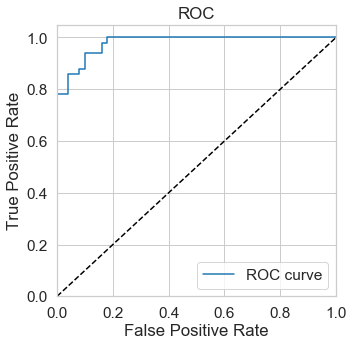

In [8]:
fpr, tpr, thresholds = metrics.roc_curve(dataset_ecc['label'], 
                                         dataset_ecc['Eccentricity'], pos_label=1)

plt.figure(figsize=(5,5))
compomics_import.plot_ROC(fpr,tpr)
plt.show()

Now consider a (terrible) classifier that classifies all lesions as malignant. In this case both the TPR and FPR equal one (top right in the ROC plot). Similarly a classifier that classifies all lesions a benign has TPR and FPR equal to zero (bottom left in the ROC plot). In general classifiers with (TPR,FPR) values on the dashed line are said to have no predictive (or random) power. 

For more accurate classifiers there will be a **trade-off** between TPR and FPR controlled by the value of $t$, as is shown by the blue ROC curve for our classifier. For instance if we want our classifier to classify all malignant lesions correctly then we can see from the ROC curve that we have to allow a FPR close to 0.2 to achieve this.

The ROC curve is often summarized as one value by computing the area under the ROC curve, known as **AUC (area under the ROC curve)**. The AUC is a decision boundary independent metric for classification performance. 

In scikit-learn it can be computed as follows:

In [9]:
print("AUC = {0:.4f}".format(metrics.roc_auc_score(dataset_ecc['label'], dataset_ecc['Eccentricity'])))

AUC = 0.9792


The higher the AUC the better the classification performance of the classifier. Peter can use the ROC curve to decide on the optimal value for $t$. 

Let's say we are not totally satisﬁed by the performance of our classifier. We could search for an even more discriminative feature. But suppose no other feature exist (or we can't find one) that is more distinctive. 

To improve classiﬁcation performance we must resort to the use of **more than one feature** at a time, known as **multivariate analysis**. Let's say we add another feature to the feature extraction unit: the solidity of a lesion. 

Now our data set looks like this:

In [10]:
#Load csv file into python variable
dataset_mel = pd.read_csv("melanoma.csv",sep='\t')
print(dataset_mel.head())
print()
print("Shape of data set: {}".format(str(dataset_mel.shape)))

   Eccentricity  Solidity  label
0     -0.598720 -2.863001      0
1     -0.518611  0.126108      0
2     -1.843886 -2.163015      0
3     -0.289294 -1.502928      0
4     -1.177039 -2.112436      0

Shape of data set: (600, 3)


Let's look at how the feature 'Solidity' discriminates the classes:

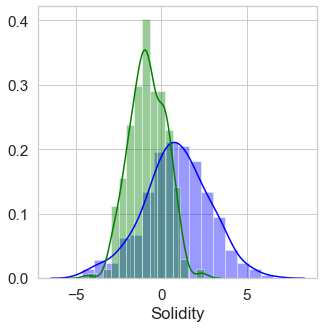

In [11]:
plt.figure(figsize=(5,5))
sns.distplot(dataset_mel[dataset_mel['label']==1]['Solidity'], color="b")
sns.distplot(dataset_mel[dataset_mel['label']==0]['Solidity'], color="g")
plt.show()

The feature extraction unit has reduced each lesion in the images to a vector of two features (or **feature vector**)
$x$. The 'label' column is typically refered to separately as $y$. 

The feature vectors can be plotted in an Eucledain vector space:

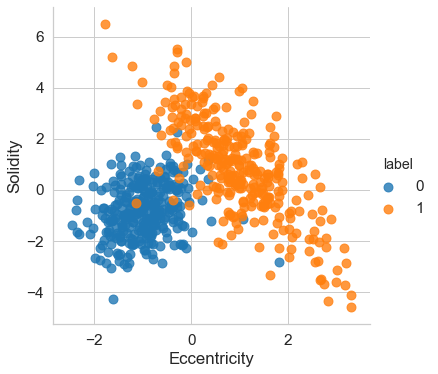

In [12]:
sns.lmplot(x="Eccentricity", y="Solidity", data=dataset_mel, hue='label', 
           fit_reg=False, size=5.5, scatter_kws={"s": 80})
plt.show()

Now we have to find a decision boundary that separates the two classes in this **feature space**.

As we will see there are many ways of computing accurate decision boundaries in feature space. 

A simple example is the **linear decision boundary**:

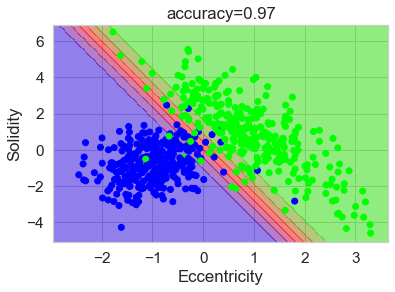

In [13]:
from sklearn.svm import SVC

X = dataset_mel[['Eccentricity','Solidity']]
y = dataset_mel['label']

model =  SVC(kernel="linear",C=1,probability=True)
model.fit(X, y)

compomics_import.plot_decision_boundary(model,X,y)
plt.show()

This scatter plot suggests the following rule for classifying the feature vectors (lesions): classify the vector as malignant with high confidence if it is located in the green zone; classify it with high confidence as benign if it is in the blue zone; and classify it with lower confidence (depending on whether it is more green or more blue). 

This two-dimensional decision boundary appears to do a good job of separating the lesions in the data set and suggests that perhaps incorporating **yet more features** would be desirable. But when we uses more than three features we can't plot the feature vectors anymore as we did above. Now it becomes hard to find an accurate decision boundary.

How can we quantify how good a certain set of features allows for a correct diagnosis if he can’t look at the decision boundary? Also, even if the difﬁculty or computational cost in attaining more features is of no concern, might we ever have **too many features**? Could adding more features decrease the classiﬁcation performance of the instrument? These are the types of concerns studied by the field of Machine Learning.

Suppose that other features are too expensive to measure, or provide little improvement, or even degrade the performance, and that we are forced to implement a classiﬁer unit based on the two features. If the models of benign and malignant cells were extremely complicated, the classiﬁer could have a decision boundary **more complex** than a simple straight line. For instance by constructing a decision boundary based on a decision tree:

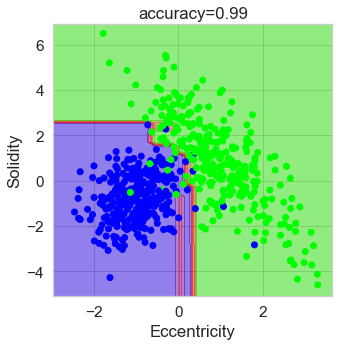

In [14]:
from sklearn.tree import DecisionTreeClassifier

model =  DecisionTreeClassifier(max_depth=5,random_state=0)
model.fit(X, y)
plt.figure(figsize=(5,5))
compomics_import.plot_decision_boundary(model,X,y)
plt.show()

So which decision boundary is best? 

The **central aim** of designing the instrument is to correctly classify **unseen** lesions not yet in our data set. This is the concept of **generalization**. It is unlikely that the complex decision tree boundary will provide good *generalization*, since it seems to be ‘ﬁtted’ too well to the feature vectors, rather than some underlying characteristics or true model of malignant and benign lesions. This is known as **overfitting** and signiﬁcantly complicates the construction of the classiﬁer unit in Peter’s instrument. In contrast, if the linear decision boundary would not be complex enough to capture the difference between malignant and benign lesions then we would call this **underfitting**.

Naturally, a more effective approach to improve the generalization performance of our classifier would be to ﬁnd more labeled images to obtain a better estimate of the true underlying characteristics. However, the lesions in our data set were validated by experts one at a time and important issues such as 'no time' and 'no money' arise. 

Rather, we might seek to ‘simplify’ the recognizer motivated by a belief that the underlying models will not require a to complex decision boundary. Indeed, he might be satisﬁed with the slightly poorer data set performance of the simpler linear boundary, if that means that the classiﬁer will have **better performance on novel lesions**. 

So far we have seen many very important elements of machine learning. The following chapters will describe these in much more detail. But before we continue we look at two other important topics.

First, feature values can have different scales (have different minimum and maximimum values). In machine learning it is good practice to remove these differences in scale between the features before starting any analysis. This data pre-prcessing is called **normalization**. 

Here for instance we see a data set with 20 features (gene expression measurements) that are clearly at different scales:

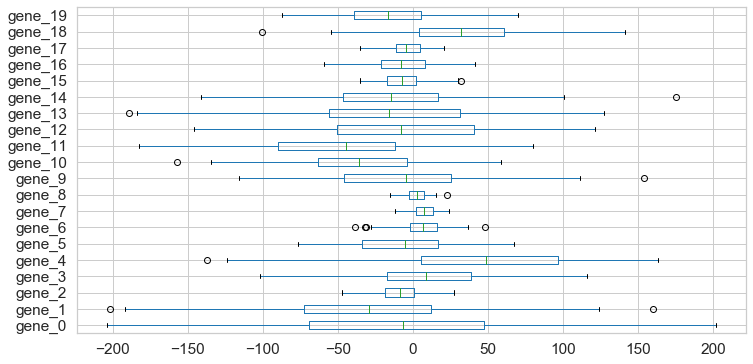

In [15]:
dataset_unscaled = pd.read_csv('unscaled_dataset.csv',sep=',')
plt.figure(figsize=(12,6))
dataset_unscaled.boxplot(vert=False)
plt.show()

The two most common methods for feature vector normalization are **standardization** and **scaling**.

Standardization (or **Z-score normalization**) scales the features such that they'll have the properties of a standard normal distribution ($\mu = 0$ and $\sigma = 1$):

\begin{equation} x_{norm} = \frac{x - \mu}{\sigma}.\end{equation} 

Standardizing the features is not only important if we are comparing measurements that have different units, but it is also a general requirement for many machine learning algorithms. Here are all the features are standardized:

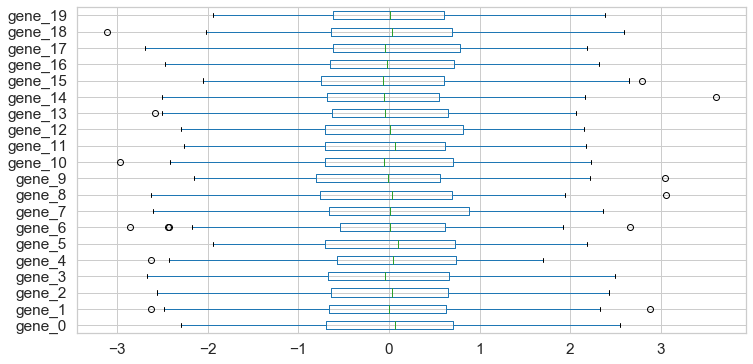

In [16]:
from sklearn.preprocessing import StandardScaler

dataset_unscaled_cols = dataset_unscaled.columns.values
scaler = StandardScaler()
scaler.fit(dataset_unscaled)
dataset_stand = pd.DataFrame(scaler.transform(dataset_unscaled),columns=dataset_unscaled_cols)
plt.figure(figsize=(12,6))
dataset_stand.boxplot(vert=False)
plt.show()

Another popular approach is to scale the features to a fixed range, usually 0 to 1. This is known as **min-max scaling** and is computed as

\begin{equation} x_{norm} = \frac{x - x_{min}}{x_{max}-x_{min}}, \end{equation}

where $x_{min}$ and $x_{max}$ are the minimum and maximum value for $x$ respectively. Here we perform min-max scaling of the features in the original data set:

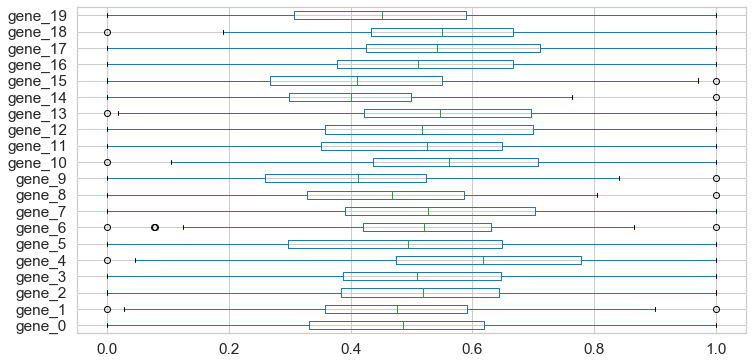

In [17]:
from sklearn.preprocessing import MinMaxScaler

dataset_unscaled_cols = dataset_unscaled.columns.values
scaler = MinMaxScaler()
scaler.fit(dataset_unscaled)
dataset_norm = pd.DataFrame(scaler.transform(dataset_unscaled),columns=dataset_unscaled_cols)
plt.figure(figsize=(12,6))
dataset_norm.boxplot(vert=False)
plt.show()

The second topic concerns the different types of features. 

So far we have seen **continuous** features with values that are ordered numerically and equally spaced. These are typically obtained from machine measurements. 

There exist also **categorical** features for which the values are not ordered. For instance the values 'green', 'red' and 'yellow' for a feature that represents color. 

In between there are the **ordinal** features. Such a feature is ordered, but the spacing is not necessarily uniform (and usually unknown). These are for instance obtained from questionnaires such as the values 'very bad', 'bad', 'good' and 'very good' for a feature that measures opinion.

It is import to understand how different machine learning algorithms deal with different types of features.